# Malaria Detection by Shoaib Hoque

In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
import tensorflow as tf
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, InputLayer, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy

## Data Preparation

### Data Loading

In [14]:
dataset, dataset_info = tfds.load('malaria', with_info=True, as_supervised=True, shuffle_files=True, split=['train'])

In [15]:
def splits(dataset, train_ratio, val_ratio, test_ratio):
  dataset_size = len(dataset)

  train_dataset = dataset.take(int(dataset_size * train_ratio))
  val_test_dataset = dataset.skip(int(dataset_size * train_ratio))
  val_dataset = val_test_dataset.take(int(dataset_size * val_ratio))
  test_dataset = val_test_dataset.skip(int(dataset_size * val_ratio))

  return train_dataset, val_dataset, test_dataset

In [16]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1

train_dataset, val_dataset, test_dataset = splits(dataset[0], train_ratio, val_ratio, test_ratio)
print(list(train_dataset.take(1).as_numpy_iterator()), list(val_dataset.take(1).as_numpy_iterator()), list(test_dataset.take(1).as_numpy_iterator()))

[(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8), 1)] [(array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
     

## Data Visualization

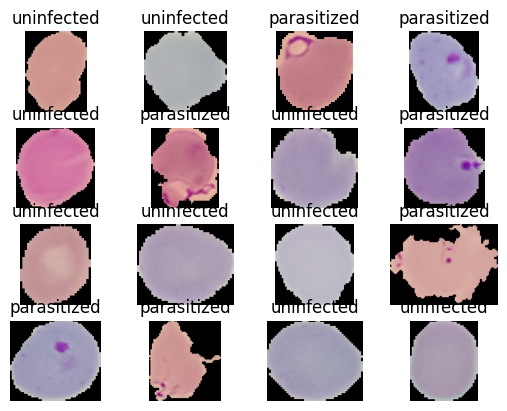

In [17]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  plt.subplot(4, 4, i+1)
  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

## Data Preprocessing

In [18]:
iamge_size = 224
batch_size = 32
def preprocess(image, label):
  image = tf.cast(image, tf.float32)
  image = tf.image.resize(image, (iamge_size, iamge_size))
  image = image/255.0
  return image, label

In [19]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)
test_dataset = test_dataset.map(preprocess)

In [20]:
for image, label in train_dataset.take(1):
  print(image.shape, label)

(224, 224, 3) tf.Tensor(1, shape=(), dtype=int64)


In [21]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration=True).batch(batch_size).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(batch_size)

## Model Creation

In [26]:
model = tf.keras.Sequential([ InputLayer(input_shape=(iamge_size, iamge_size, 3)),
                             Conv2D(filters = 6, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                             BatchNormalization(),
                             MaxPooling2D(pool_size = 2, strides = 2),


                            Conv2D(filters = 16, kernel_size = 3, strides = 1, padding = 'valid', activation = 'relu'),
                            BatchNormalization(),
                            MaxPooling2D(pool_size = 2, strides = 2),

                            Flatten(),

                             Dense(units = 100, activation = 'relu'),
                             BatchNormalization(),
                             Dense(units = 10, activation = 'relu'),
                             BatchNormalization(),

                             Dense(units = 1, activation = 'sigmoid'),
])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 111, 111, 6)       0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      64        
 chNormalization)                                                
                                                      

In [27]:
model.compile(optimizer = Adam(learning_rate = 0.01), loss = BinaryCrossentropy(), metrics = ['accuracy'])

In [29]:
history = model.fit(train_dataset, epochs = 20, validation_data = val_dataset, verbose=1)

Epoch 1/20
689/689 [==============================] - 45s 64ms/step - loss: 0.2000 - accuracy: 0.9312 - val_loss: 0.8106 - val_accuracy: 0.8171
Epoch 2/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1933 - accuracy: 0.9341 - val_loss: 0.2564 - val_accuracy: 0.9303
Epoch 3/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1708 - accuracy: 0.9434 - val_loss: 0.1601 - val_accuracy: 0.9474
Epoch 4/20
689/689 [==============================] - 50s 72ms/step - loss: 0.1484 - accuracy: 0.9494 - val_loss: 0.2831 - val_accuracy: 0.9176
Epoch 5/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1441 - accuracy: 0.9505 - val_loss: 0.3120 - val_accuracy: 0.9064
Epoch 6/20
689/689 [==============================] - 43s 62ms/step - loss: 0.1381 - accuracy: 0.9530 - val_loss: 0.1801 - val_accuracy: 0.9426
Epoch 7/20
689/689 [==============================] - 50s 73ms/step - loss: 0.1215 - accuracy: 0.9587 - val_loss: 0.1680 - val_accuracy:

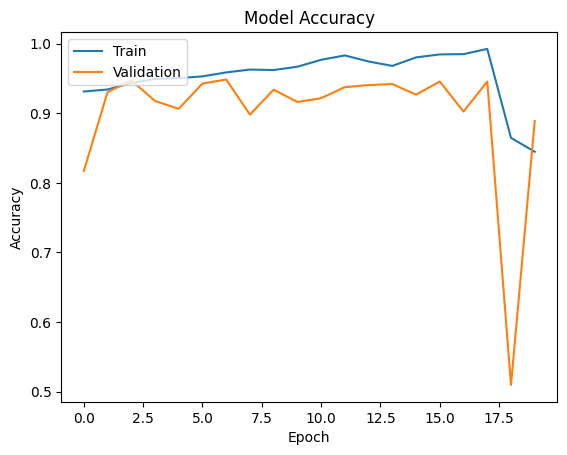

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')
plt.show()

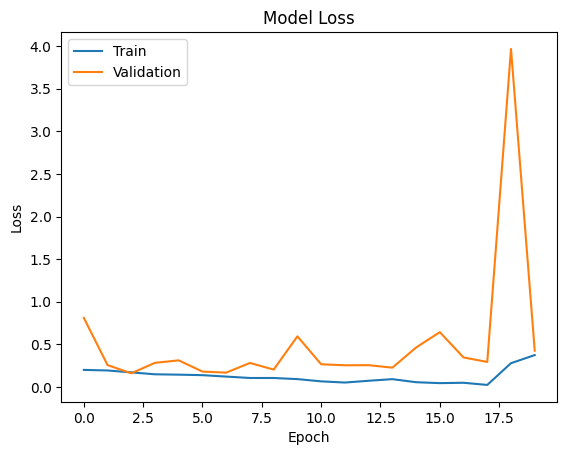

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc = 'upper left')